# Library

In [6]:
%matplotlib inline

import os
import json

import PIL
import cv2
import albumentations as A

import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

from tqdm import tqdm
from pycocotools.coco import COCO

from itertools import zip_longest

# Utils

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


def display_multiple_img(images: np.ndarray, images_path: str, cols: int = 2):
    """ Function for multiple images visualiztaion """
    assert (images.shape[0] % cols) == 0

    for imagename_pair in images.reshape(-1, cols):
        _, axs = plt.subplots(nrows = 1, ncols = cols, figsize = (10, 10))

        for ind, imagename in enumerate(imagename_pair):
            image = cv2.imread(
                os.path.join(images_path, imagename)
            )
            axs[ind].imshow(image[:,:,::-1])
            axs[ind].set_title(imagename + ' ' + str(image.shape))
            axs[ind].axis('off')

In [8]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image


def get_images_metainfo(images_list: np.ndarray, images_path: str):
    """Read metadata of images

    Returns:
        List: list of dicts with keys: imagename,
            width, height, aspect_ratio.
    """
    metainfo = []

    for imagename in tqdm(images_list, total = images_list.shape[0]):
        current_meta = {
            'imagename': imagename,
        }

        image_path = os.path.join(images_path, imagename)
        width, height = Image.open(image_path).size

        current_meta['width'] = width
        current_meta['height'] = height
        current_meta['aspect_ratio'] = width/height
        metainfo.append(current_meta)

    return metainfo

# Constants

In [9]:
data_path = '/content/drive/MyDrive/level2-pstage/data'
images_path = os.path.join(data_path, 'train')
annotations_path = os.path.join(data_path, 'train.json')

# Images

## Get number of images in dataset:

In [10]:
images_list = np.array(os.listdir(images_path))
print(f'Images in dataset: {images_list.shape[0]}')

Images in dataset: 4883


## Pick random K samples from dataset

In [11]:
images_indices = np.arange(images_list.shape[0], dtype='int')
np.random.shuffle(images_indices)

## Visualize images

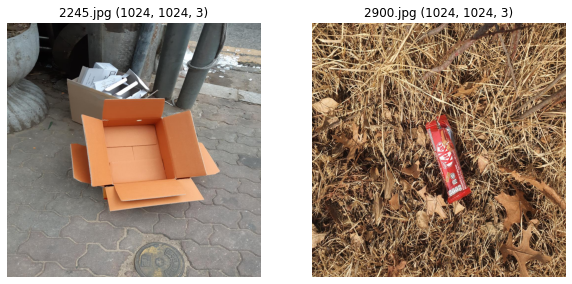

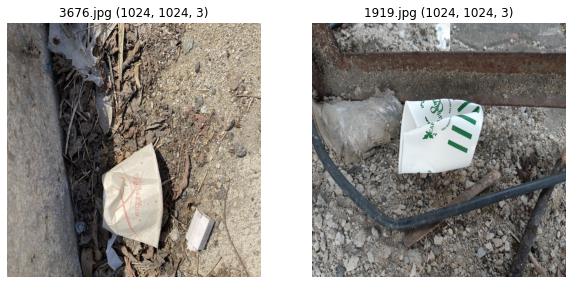

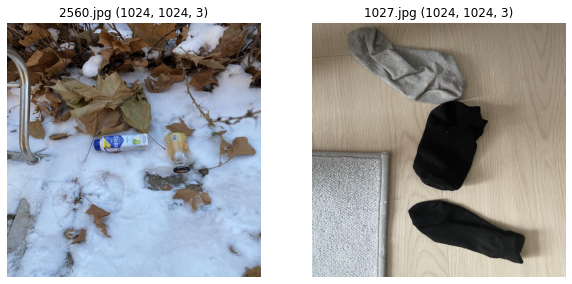

In [12]:
k = 6
first_k_images = images_list[images_indices][:k]

display_multiple_img(
    images=first_k_images,
    images_path=images_path,
    cols=2
)

## read metainfo of the images

In [13]:
metainfo = get_images_metainfo(
    images_list=images_list,
    images_path=images_path
)

metainfo_df = pd.DataFrame(metainfo)
metainfo_df

100%|██████████| 4883/4883 [02:16<00:00, 35.90it/s] 


,imagename,width,height,aspect_ratio
0,2384.jpg,1024,1024,1.0
1,2192.jpg,1024,1024,1.0
2,4705.jpg,1024,1024,1.0
3,2528.jpg,1024,1024,1.0
4,2533.jpg,1024,1024,1.0
...,...,...,...,...
4878,1076.jpg,1024,1024,1.0
4879,0304.jpg,1024,1024,1.0
4880,0652.jpg,1024,1024,1.0
4881,0264.jpg,1024,1024,1.0


## inspect images sizes and aspect ratios

In [14]:
metainfo_df.describe()

,width,height,aspect_ratio
count,4883.0,4883.0,4883.0
mean,1024.0,1024.0,1.0
std,0.0,0.0,0.0
min,1024.0,1024.0,1.0
25%,1024.0,1024.0,1.0
50%,1024.0,1024.0,1.0
75%,1024.0,1024.0,1.0
max,1024.0,1024.0,1.0


# Annotations

## read annotations

In [15]:
# json 파일을 읽고 key별로 정보 저장
with open(annotations_path, 'r') as f:
    train_json = json.loads(f.read())
    
images = train_json['images']
categories = train_json['categories']
annotations = train_json['annotations']

# categories_names: category_id와 이름을 매핑해주는 변수
categories_names = []
for cat_dict in categories:
    categories_names.append(cat_dict['name'])
    
# coco: train_json파일을 COCO api형태로 불러온 변수
coco = COCO(annotations_path)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [16]:
dataset = []

for idx in range(0, images_list.shape[0]): # length of train images = images_list.shape[0]
    ann_ids = coco.getAnnIds(imgIds=idx) # 해당 이미지에 해당하는 annotation id들을 저장한 리스트
    ann = coco.loadAnns(ann_ids) # 해당 이미지에 해당하는 annotation 정보를 모두 담은 리스트
    
    for anno in ann:
        for index in range(0, len(categories)):
            if anno['category_id'] == index:
                classname = categories[index]['name']
        dataset.append({'filename' : images[idx]['file_name'].split("/")[-1], 'classname' : classname, **anno})

dataset_df = pd.DataFrame(dataset)
dataset_df

,filename,classname,image_id,category_id,area,bbox,iscrowd,id
0,0000.jpg,General trash,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0
1,0001.jpg,Metal,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1
2,0001.jpg,Plastic bag,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2
3,0001.jpg,Glass,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3
4,0001.jpg,Plastic,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4
...,...,...,...,...,...,...,...,...
23139,4882.jpg,Plastic,4882,5,768591.81,"[0.0, 116.2, 944.1, 814.1]",0,23139
23140,4882.jpg,Plastic bag,4882,7,57309.72,"[302.1, 439.3, 265.2, 216.1]",0,23140
23141,4882.jpg,General trash,4882,0,1772.74,"[511.3, 451.1, 58.7, 30.2]",0,23141
23142,4882.jpg,Paper,4882,1,53008.67,"[255.0, 421.4, 271.7, 195.1]",0,23142


## How much annotations per image we have in the dataset?

In [17]:
print(f"하나의 이미지당 bounding box 개수 평균: {dataset_df.groupby('filename')['bbox'].count().mean():.2f}")

하나의 이미지당 bounding box 개수 평균: 4.74


## How much samples per category we have in the dataset?

In [18]:
# ! pip install kaleido # fig.show('png')

print(dataset_df['classname'].unique())
fig = px.histogram(dataset_df, x='classname', title='Histogram of categories')
fig.update_xaxes(categoryorder='total descending')
fig.show()

['General trash' 'Metal' 'Plastic bag' 'Glass' 'Plastic' 'Paper pack'
 'Styrofoam' 'Paper' 'Clothing' 'Battery']


## What is the area of the boxes we have in the dataset?

In [19]:
dataset_df['area'] = dataset_df['bbox'].apply(lambda x: (x[2] - x[0]) * (x[3] - x[1]))
fig = px.histogram(dataset_df, x='area', title='Historgram of bounding boxes area')
fig.show()

In [20]:
dataset_df['area'].describe()

count    2.314400e+04
mean     7.607212e+04
std      1.540767e+05
min     -8.574405e+05
25%     -5.842560e+03
50%      3.403477e+04
75%      1.304585e+05
max      1.048371e+06
Name: area, dtype: float64

In [21]:
agg_by_classname = dataset_df.groupby('classname')['area',].mean()

fig = px.bar(
    agg_by_classname,
    x=agg_by_classname.index, 
    y='area',
    title='Mean area of bounding box per category' 
)
fig.update_xaxes(categoryorder='total descending')
fig.show()

## Visualize aspect ratio for bounding boxes in the annotations

In [22]:
def count_box_ratio(x):
    try:
        return (x[2] - x[0]) / (x[3] - x[1])
    except ZeroDivisionError as e:
        return 0

dataset_df['box_ratio'] = dataset_df['bbox'].apply(count_box_ratio)
fig = px.histogram(dataset_df, x='box_ratio', title='Histogram of bounding box aspect ratio')
fig.show()

# Visualize dataset annotations
## Visualize all annotations

In [23]:
def grouper(iterable, n, fillvalue=None):
    """Collect data into fixed-length chunks or blocks"""
    
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

In [24]:
cols = 2
limit = 100

cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

dataset_grouped = grouper(dataset_df[:limit].groupby('filename'), n=2)

for _, grouped_pairs in enumerate(dataset_grouped):
    figure, ax = plt.subplots(nrows = 1, ncols = cols, figsize = (25, 25))

    for ind, current_sample in enumerate(grouped_pairs):
        if not current_sample:
            break

        (imagename, sample) = current_sample
        image = cv2.imread(
            os.path.join(images_path, imagename.split("/")[-1])
        )
        for i, row in sample.iterrows():
            color = colors[int(i) % len(colors)]
            color = [i * 255 for i in color]
            
            coordinates = [
                (row['bbox'][0], row['bbox'][1]),
                (row['bbox'][2], row['bbox'][3]),
            ]
            cv2.rectangle(img=image, pt1=(int(coordinates[0][0]), int(coordinates[0][1])), pt2=(int(coordinates[1][0]), int(coordinates[1][1])), color=color, thickness=int(4*image.shape[1]/640))
            cv2.putText(image, row['classname'], 
                        (int(coordinates[0][0]), int(coordinates[0][1] - int(10*image.shape[1]/640))), cv2.FONT_HERSHEY_SIMPLEX, 
                        int(1*image.shape[1]/640), (255,255,255), int(3*image.shape[1]/640))

        ax[ind].set_title(image.shape)
        ax[ind].imshow(image[:,:,::-1])